In [1]:
import sys
import time
import IPython.display as display

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# ✅ Install YOLOv8
!pip install ultralytics --quiet

# 📦 Imports
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from ultralytics import YOLO
from google.colab import files

# VOC classes
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.8/974.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ult

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch

def load_faster_rcnn_model(checkpoint_path):
    from torchvision.models.detection import fasterrcnn_resnet50_fpn
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

    model = fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=21)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model



In [5]:
def get_image():
    method = input("Upload or URL? [upload/url] ").strip().lower()

    if method == "upload":
        uploaded = files.upload()
        file_name = next(iter(uploaded))
        image = Image.open(file_name).convert("RGB")
    elif method == "url":
        url = input("Paste image URL: ").strip()
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        raise ValueError("Invalid input method.")

    return image


In [6]:
def run_inference(model_name, image, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(10, 8))
    ax.imshow(image)

    if model_name == "rcnn":
        try:
            model = load_faster_rcnn_model("/content/drive/MyDrive/ACV_Assignment_3/fasterrcnn_final.pth")
        except Exception as e:
            raise RuntimeError(f"Failed to load Faster R-CNN model: {e}")

        img_tensor = F.to_tensor(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_tensor)[0]

        num_preds = 0
        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score >= threshold:
                num_preds += 1
                x1, y1, x2, y2 = box.cpu().numpy()
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1 - 5, f"{VOC_CLASSES[label]}: {score:.2f}",
                        color='white', fontsize=10, backgroundcolor='red')

    elif model_name == "yolo":
        try:
            model = YOLO("/content/drive/MyDrive/ACV_Assignment_3/yolov8_best.pt")
        except Exception as e:
            raise RuntimeError(f"Failed to load YOLOv8 model: {e}")

        try:
            result = model(image, conf=threshold)[0]
            boxes = result.boxes
        except Exception as e:
            raise RuntimeError(f"Inference failed for YOLOv8: {e}")

        num_preds = len(boxes)
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
            score = float(box.conf[0])
            class_id = int(box.cls[0])
            label = model.names[class_id]
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"{label}: {score:.2f}",
                    color='black', fontsize=10, backgroundcolor='lime')

    else:
        raise ValueError("Invalid model name.")

    plt.axis('off')
    plt.title(f"{model_name.upper()} Prediction — {num_preds} objects")
    plt.show()

    plt.pause(0.001)  # Helps avoid input hang in notebooks
    plt.close()        # ✅ Avoids figure buildup in loop
    # Flush stdout before prompting again (important in Colab)
    import sys
    sys.stdout.flush()
    time.sleep(0.1)  # Give Colab time to refresh
    display.display(display.HTML("<script>window.scrollTo(0, document.body.scrollHeight);</script>"))

In [ ]:
!ls "/content/drive/MyDrive/ACV_Assignment_3"

ACV_Assignment3_RCNN.ipynb    fasterrcnn_epoch_6.pth
ACV_Assignment3_YoloV8.ipynb  fasterrcnn_epoch_7.pth
fasterrcnn_epoch_10.pth       fasterrcnn_epoch_8.pth
fasterrcnn_epoch_1.pth	      fasterrcnn_epoch_9.pth
fasterrcnn_epoch_2.pth	      fasterrcnn_final.pth
fasterrcnn_epoch_3.pth	      Model.ipynb
fasterrcnn_epoch_4.pth	      VOCtrainval_06-Nov-2007.tar
fasterrcnn_epoch_5.pth	      yolov8_best.pt


Saving dog.jpeg to dog.jpeg


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


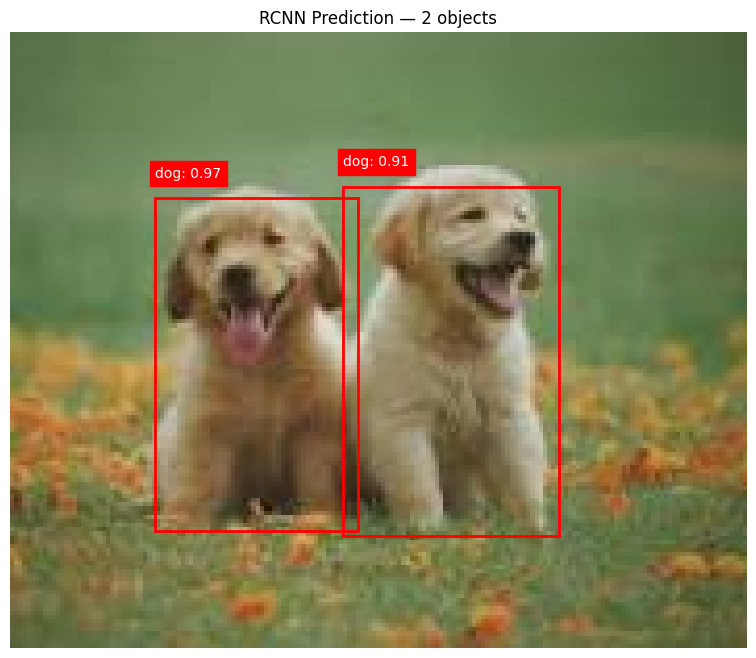

Saving bus.jpg to bus.jpg

0: 640x480 1 bus, 3 persons, 43.3ms
Speed: 23.3ms preprocess, 43.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


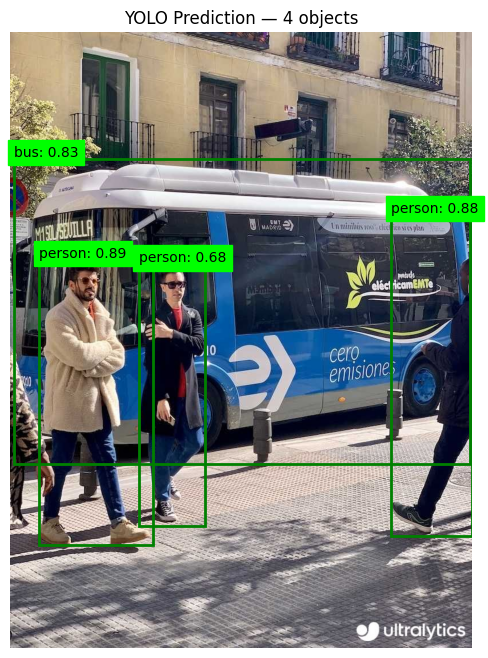

Saving Air-India-Boeing-787-8-Dreamliner-VT-ANL-3-25-19-William-Derrickson-scaled.jpg to Air-India-Boeing-787-8-Dreamliner-VT-ANL-3-25-19-William-Derrickson-scaled.jpg


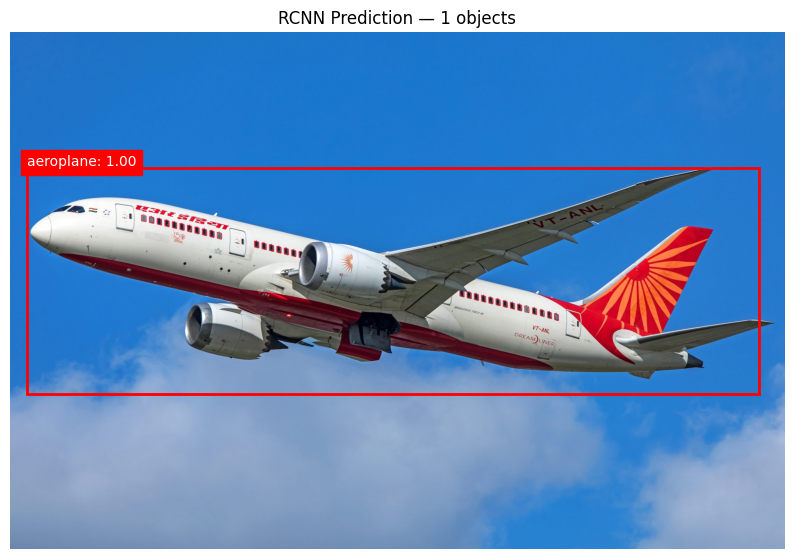

In [ ]:
import IPython
IPython.display.clear_output(wait=False)  # Ensure prompt refreshes properly

while True:
    model_choice = input("Choose model [rcnn/yolo]: ").strip().lower()
    if model_choice not in ["rcnn", "yolo"]:
        print("❌ Invalid model selection. Try again.")
        continue

    try:
        img = get_image()
        run_inference(model_choice, img, threshold=0.5)
    except Exception as e:
        print(f"❌ Error: {e}")

    repeat = input("Run again? [y/n]: ").strip().lower()
    if repeat != "y":
        print("👋 Exiting the program.")
        break
